In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT_merging(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 4, 128)
[4, 128]


In [12]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 2, 64, 256)        4352  

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
162/162 [==============================] - 23s 52ms/step - loss: 1.9585 - val_loss: 5.6218
Epoch 2/100
162/162 [==============================] - 8s 46ms/step - loss: 1.6638 - val_loss: 5.6728
Epoch 3/100
162/162 [==============================] - 7s 46ms/step - loss: 1.6113 - val_loss: 4.6756
Epoch 4/100
162/162 [==============================] - 8s 47ms/step - loss: 1.5806 - val_loss: 2.2957
Epoch 5/100
162/162 [==============================] - 8s 46ms/step - loss: 1.5541 - val_loss: 1.6229
Epoch 6/100
162/162 [==============================] - 8s 46ms/step - loss: 1.5360 - val_loss: 1.4743
Epoch 7/100
162/162 [==============================] - 8s 46ms/step - loss: 1.4951 - val_loss: 1.4919
Epoch 8/100
162/162 [==============================] - 8s 47ms/step - loss: 1.4666 - val_loss: 1.4276
Epoch 9/100
162/162 [==============================] - 8s 46ms/step - loss: 1.4257 - val_loss: 1.4657
Epoch 10/100
162/162 [==============================] - 8s 48ms/step - loss: 1.36

# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 1s 15ms/step - loss: 1.1888
1.1887916326522827


## Loss

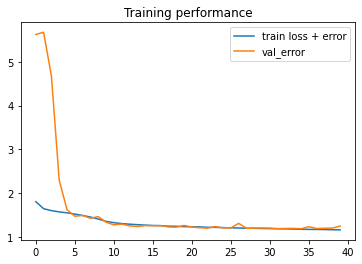

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

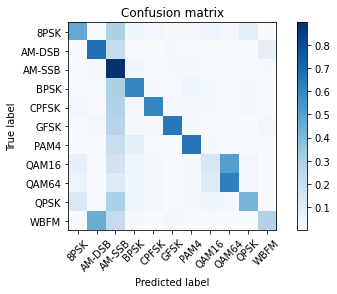

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08803863298662705
Overall Accuracy:  0.09611829944547134
Overall Accuracy:  0.09791445740544362
Overall Accuracy:  0.1163035839775123
Overall Accuracy:  0.15209537572254336
Overall Accuracy:  0.25420694593626925
Overall Accuracy:  0.3550698674310283
Overall Accuracy:  0.46656976744186046
Overall Accuracy:  0.5743698970536031
Overall Accuracy:  0.6966211358734723
Overall Accuracy:  0.760711692084241
Overall Accuracy:  0.7966101694915254
Overall Accuracy:  0.8060721062618595
Overall Accuracy:  0.8197761194029851
Overall Accuracy:  0.8234870317002881
Overall Accuracy:  0.8304775792927451
Overall Accuracy:  0.8163643095149945
Overall Accuracy:  0.8164723580293344
Overall Accuracy:  0.8279292557111275
Overall Accuracy:  0.814336917562724


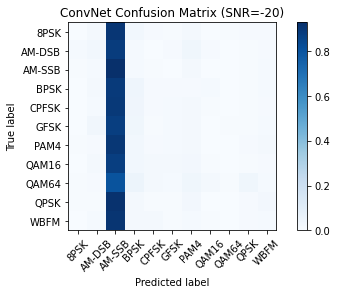

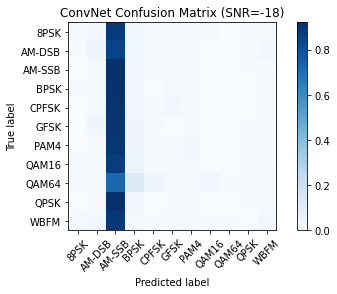

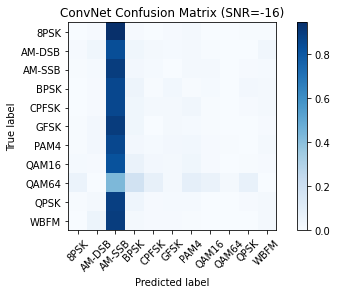

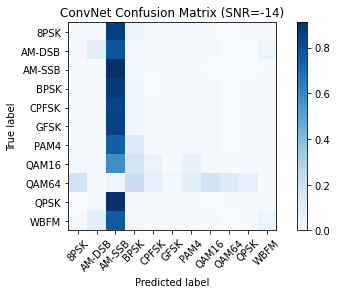

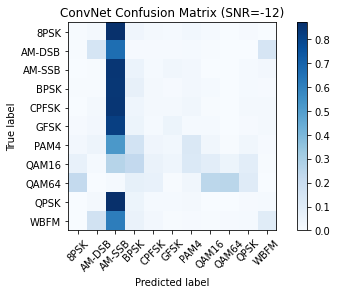

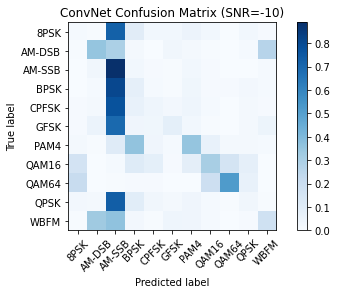

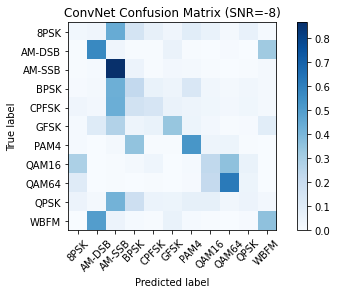

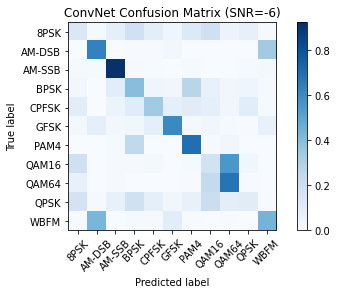

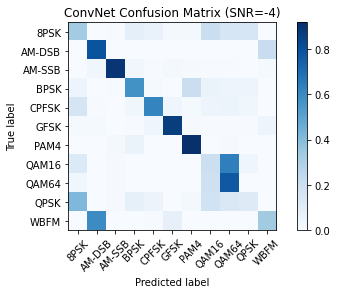

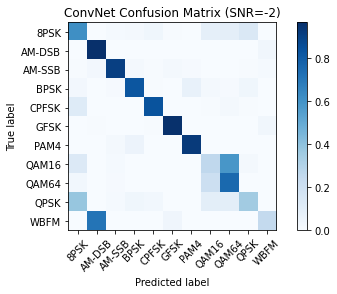

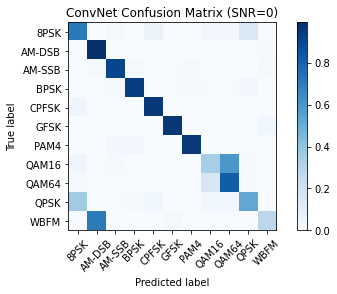

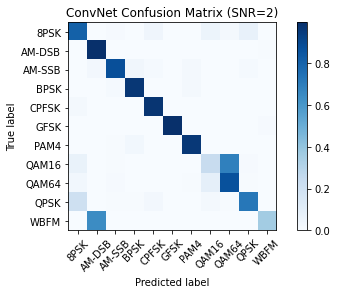

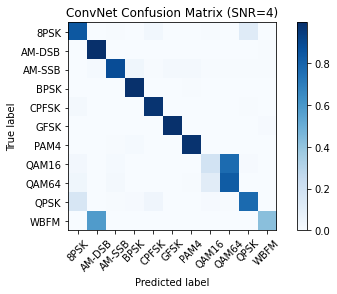

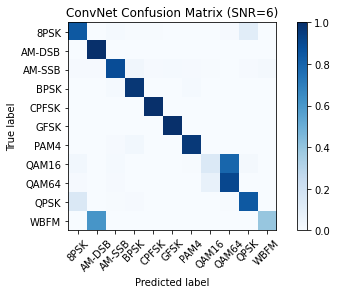

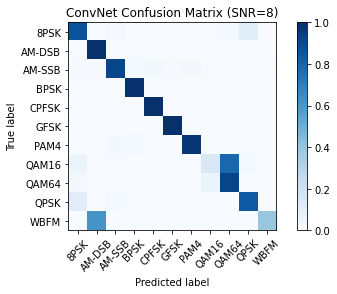

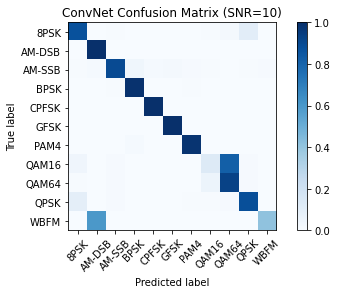

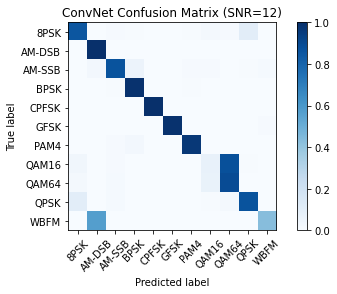

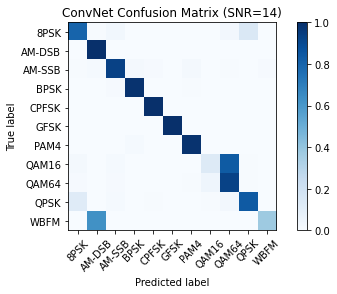

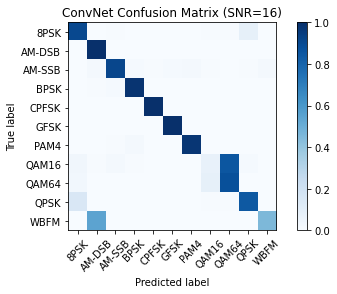

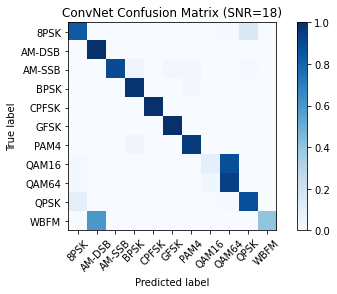

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,15,25,35,46,57,69,76,79,80,81,82,83,81,81,82,81


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

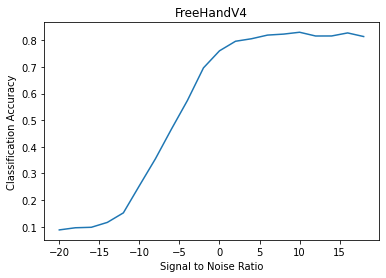

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)